In [33]:
# For loading Packages
import pandas as pd

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# For mathematical calculations
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# To build and evaluate model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.tree import plot_tree, DecisionTreeClassifier

import tensorflow as tf
# To ignore any warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train2= df_train.copy().drop(['Transported'],axis=1)

data = pd.concat([df_train2, df_test], axis = 0).reset_index(drop = True)

data.shape

(12970, 13)

In [3]:
# Data from the Cabin
data[["CabinDeck", "CabinNo.", "CabinSide"]] = data["Cabin"].str.split('/', expand = True)

In [4]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNo.,CabinSide
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S


In [5]:
data.isnull().sum().sort_values(ascending=False)

CryoSleep       310
ShoppingMall    306
Cabin           299
CabinDeck       299
CabinNo.        299
CabinSide       299
VIP             296
Name            294
FoodCourt       289
HomePlanet      288
Spa             284
Destination     274
Age             270
VRDeck          268
RoomService     263
PassengerId       0
dtype: int64

In [6]:
missing_categorical_columns = data.select_dtypes(include=['object','bool']).isna().sum() > 0
missing_categorical_columns = list(missing_categorical_columns[missing_categorical_columns].index)


print(f'imputed columns: {missing_categorical_columns}')

for col in missing_categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

imputed columns: ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name', 'CabinDeck', 'CabinNo.', 'CabinSide']


In [7]:
data.isnull().sum().sort_values(ascending=False)

ShoppingMall    306
FoodCourt       289
Spa             284
Age             270
VRDeck          268
RoomService     263
PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
VIP               0
Name              0
CabinDeck         0
CabinNo.          0
CabinSide         0
dtype: int64

In [8]:
missing_numerical_columns = data.select_dtypes(include=['int','float64']).isna().sum() > 0
missing_numerical_columns = list(missing_numerical_columns[missing_numerical_columns].index)

print(missing_numerical_columns)

for col in missing_numerical_columns:
    data[col] = data[col].fillna(data[col].mean())

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [9]:
data.isnull().sum().sort_values(ascending=False)

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
CabinDeck       0
CabinNo.        0
CabinSide       0
dtype: int64

In [10]:
full_train = pd.merge(data, df_train[['PassengerId','Transported']], on='PassengerId', how='left')
full_train


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000000,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000000,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000000,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000000,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000000,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,G,1496,S,NaN
12966,9269_01,Earth,False,G/160/P,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,F,82,S,NaN
12967,9271_01,Mars,True,D/296/P,55 Cancri e,28.771969,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,D,296,P,NaN
12968,9273_01,Europa,False,D/297/P,TRAPPIST-1e,28.771969,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,D,297,P,NaN


In [11]:
full_tran = full_train.drop(columns = ['PassengerId','Cabin','Name','CabinNo.'])

In [12]:
train_full = full_tran.loc[full_tran['Transported'].notnull()]
test_full = full_tran.loc[full_tran['Transported'].isnull()]

In [13]:
print(train_full.shape)
print(test_full.shape)

(8693, 13)
(4277, 13)


In [14]:
train_full.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,P,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,S,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,S,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,S,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,S,True


In [15]:
X = train_full.drop(columns='Transported')

In [16]:
numerical_columns = X.select_dtypes(include=['int','float64']).columns
categorical_columns = X.select_dtypes(include=['object','boolean']).columns
print(numerical_columns)
print(categorical_columns)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')
Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck',
       'CabinSide'],
      dtype='object')


In [17]:
X_encoded = pd.get_dummies(X, columns=categorical_columns)


In [18]:
X_encoded

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
0,39.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0
8689,18.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
8690,26.0,0.0,0.0,1872.0,1.0,0.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [19]:
y = train_full['Transported']
y = y.astype(int)

In [34]:
model = DecisionTreeClassifier()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=78)

In [36]:
model = model.fit(X_train, y_train)

In [37]:
predictions = model.predict(X_test)

In [38]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [39]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,795,291
Actual 1,303,785


Accuracy Score : 0.7267709291628335
Classification Report
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      1086
           1       0.73      0.72      0.73      1088

    accuracy                           0.73      2174
   macro avg       0.73      0.73      0.73      2174
weighted avg       0.73      0.73      0.73      2174



In [52]:
model_2 = DecisionTreeClassifier( min_samples_split=800, random_state=40, max_depth=5)
model_2.fit(X_train, y_train)
predictions = model_2.predict(X_test)


print(classification_report(y_test, predictions))

plt.figure(figsize=(96,96))
plot_tree(model_2, feature_names=X_encoded.columns, class_names=('Not Transported', 'Transported'))
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.69      0.75      1086
           1       0.73      0.83      0.78      1088

    accuracy                           0.76      2174
   macro avg       0.77      0.76      0.76      2174
weighted avg       0.77      0.76      0.76      2174



In [46]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

display(cm_df)

,Predicted 0,Predicted 1
Actual 0,754,332
Actual 1,180,908


In [ ]:
baseline_model = RandomForestClassifier(random_state = 1)
baseline_model.fit(X_encoded, y)

RandomForestClassifier(random_state=1)

In [ ]:
# store accuracy of baseline model prediction in results
result = cross_val_score(baseline_model, X_encoded, y, cv = 20, scoring = "accuracy")

# print mean and standard deviation of baseline model
print(np.mean(result))
print(np.std(result))

0.7928213888447482
0.01696728359092661


In [ ]:
# provide range for max_depth from 1 to 40 with an interval of 2
# provide range for n_estimators from 1 to 400 with an interval of 20
paramgrid = {'max_depth': list(range(1, 20, 2)),
             'n_estimators': list(range(1, 200, 20))}
grid_search = GridSearchCV(RandomForestClassifier(random_state = 1), paramgrid)

# fit the grid search model
grid_search.fit(X_encoded, y)

# Estimating the optimized value
grid_search.best_estimator_

RandomForestClassifier(max_depth=9, n_estimators=181, random_state=1)

In [ ]:
baseline_model = RandomForestClassifier(max_depth=9, n_estimators=181, random_state = 1)
baseline_model.fit(X_encoded, y)

RandomForestClassifier(max_depth=9, n_estimators=181, random_state=1)

In [ ]:
# store accuracy of baseline model prediction in results
result = cross_val_score(baseline_model, X_encoded, y, cv = 20, scoring = "accuracy")

# print mean and standard deviation of baseline model
print(np.mean(result))
print(np.std(result))

0.7992711478362201
0.022256772576049924


In [ ]:
X_pred = test_full.drop(columns="Transported")
X_pred

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide
8693,Earth,True,TRAPPIST-1e,27.000000,False,0.0,0.0,0.0,0.0,0.0,G,S
8694,Earth,False,TRAPPIST-1e,19.000000,False,0.0,9.0,0.0,2823.0,0.0,F,S
8695,Europa,True,55 Cancri e,31.000000,False,0.0,0.0,0.0,0.0,0.0,C,S
8696,Europa,False,TRAPPIST-1e,38.000000,False,0.0,6652.0,0.0,181.0,585.0,C,S
8697,Earth,False,TRAPPIST-1e,20.000000,False,10.0,0.0,635.0,0.0,0.0,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,True,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,G,S
12966,Earth,False,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,F,S
12967,Mars,True,55 Cancri e,28.771969,False,0.0,0.0,0.0,0.0,0.0,D,P
12968,Europa,False,TRAPPIST-1e,28.771969,False,0.0,2680.0,0.0,0.0,523.0,D,P


In [ ]:
X_pred_encoded = pd.get_dummies(X_pred, columns=categorical_columns)
X_pred_encoded

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
8693,27.000000,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1
8694,19.000000,0.0,9.0,0.0,2823.0,0.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
8695,31.000000,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
8696,38.000000,0.0,6652.0,0.0,181.0,585.0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1
8697,20.000000,10.0,0.0,635.0,0.0,0.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,34.000000,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1
12966,42.000000,0.0,847.0,17.0,10.0,144.0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
12967,28.771969,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0
12968,28.771969,0.0,2680.0,0.0,0.0,523.0,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
tree_preds = baseline_model.predict(X_pred_encoded)

In [ ]:
tree_preds = pd.DataFrame(tree_preds.astype(bool))
tree_preds

,0
0,True
1,False
2,True
3,True
4,True
...,...
4272,True
4273,False
4274,True
4275,True


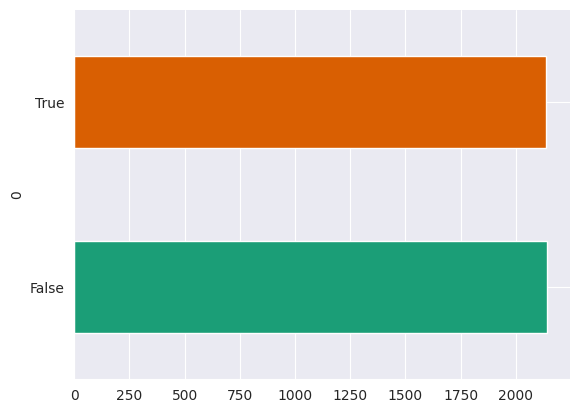

In [ ]:

tree_preds.groupby(0).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_sub = df_test.merge(tree_preds, left_index=True, right_index=True)
df_sub = df_sub.rename(columns={0:'Transported'})
df_submit = df_sub[['PassengerId','Transported']]
df_submit.set_index('PassengerId', inplace=True)
df_submit.to_csv('predictions_tree_base.csv')

In [ ]:
df_submit.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


# Neural Network

In [ ]:
X = train_full.drop(columns='Transported')
y = train_full['Transported']
y = y.astype(int)

In [ ]:
X

array([[ 0.        ,  1.        ,  0.        , ..., -0.29086415,
        -0.27661358, -0.26905954],
       [ 1.        ,  0.        ,  0.        , ..., -0.24901496,
         0.21155511, -0.23023124],
       [ 0.        ,  1.        ,  0.        , ..., -0.29086415,
         5.69433863, -0.22581893],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  2.84280332,
        -0.27572438, -0.26905954],
       [ 0.        ,  1.        ,  0.        , ..., -0.29086415,
         0.03727267,  2.58570344],
       [ 0.        ,  1.        ,  0.        , ..., -0.29086415,
        -0.27661358, -0.25847   ]])

In [ ]:
y

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 8693, dtype: int64

In [ ]:
numerical_columns = X.select_dtypes(include=['int','float64']).columns
categorical_columns = X.select_dtypes(include=['object','boolean']).columns

print(numerical_columns)
print(categorical_columns)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')
Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck',
       'CabinSide'],
      dtype='object')


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('numeric', StandardScaler(), numerical_columns)
        ])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.704388,-0.335550,-0.286156,-0.280735,-0.282093,-0.264384
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.983617,-0.007855,0.264860,-0.280735,-0.282093,-0.264384
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.342720,-0.307617,0.133311,-0.280735,-0.258709,-0.264384
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.901178,-0.335550,-0.286156,-0.182005,-0.282093,1.435701
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.552142,0.203999,-0.111792,-0.280735,-0.282093,-0.137939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6949,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.634581,0.967013,-0.286156,0.736186,-0.282093,-0.264384
6950,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.704388,-0.335550,-0.124202,0.007073,1.364626,1.291934
6951,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.342720,-0.007855,-0.266300,-0.267571,-0.282093,-0.264384
6952,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.262845,-0.335550,-0.286156,-0.280735,-0.282093,-0.264384


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(units=100, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(units=80, activation='relu'),
    tf.keras.layers.Dense(units=80, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               2700      
                                                                 
 dense_9 (Dense)             (None, 80)                8080      
                                                                 
 dense_10 (Dense)            (None, 80)                6480      
                                                                 
 dense_11 (Dense)            (None, 1)                 81        
                                                                 
Total params: 17341 (67.74 KB)
Trainable params: 17341 (67.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=100, verbose=True)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

55/55 [==============================] - 0s 2ms/step - loss: 0.9100 - accuracy: 0.7769
Test accuracy: 0.7768832445144653, Test loss: 0.9100061058998108


In [ ]:
X = preprocessor.fit_transform(X)
pd.DataFrame(X)

In [ ]:
model.fit(X,y,epochs=100, verbose=True )

In [ ]:
X_pred = test_full.drop(columns="Transported")
X_pred

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide
8693,Earth,True,TRAPPIST-1e,27.000000,False,0.0,0.0,0.0,0.0,0.0,G,S
8694,Earth,False,TRAPPIST-1e,19.000000,False,0.0,9.0,0.0,2823.0,0.0,F,S
8695,Europa,True,55 Cancri e,31.000000,False,0.0,0.0,0.0,0.0,0.0,C,S
8696,Europa,False,TRAPPIST-1e,38.000000,False,0.0,6652.0,0.0,181.0,585.0,C,S
8697,Earth,False,TRAPPIST-1e,20.000000,False,10.0,0.0,635.0,0.0,0.0,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...
12965,Earth,True,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,G,S
12966,Earth,False,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,F,S
12967,Mars,True,55 Cancri e,28.771969,False,0.0,0.0,0.0,0.0,0.0,D,P
12968,Europa,False,TRAPPIST-1e,28.771969,False,0.0,2680.0,0.0,0.0,523.0,D,P


In [ ]:
X_pred = preprocessor.transform(X_pred)
pd.DataFrame(X_pred)

In [ ]:
predictions = (model.predict(X_pred)[:,0]>0.5).astype(bool)

134/134 [==============================] - 0s 2ms/step


In [ ]:
pred_nn=pd.DataFrame(predictions)
pred_nn

,0
0,True
1,False
2,True
3,True
4,True
...,...
4272,True
4273,True
4274,True
4275,True


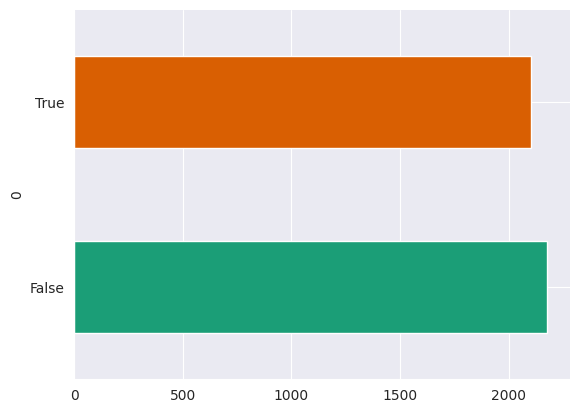

In [ ]:

pred_nn.groupby(0).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [ ]:
df_sub = df_test.merge(pred_nn, left_index=True, right_index=True)
df_sub = df_sub.rename(columns={0:'Transported'})
df_submit = df_sub[['PassengerId','Transported']]
df_submit.set_index('PassengerId', inplace=True)
df_submit.to_csv('predictions_3.csv')